In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from ydata_profiling import ProfileReport
import pickle

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [62]:
df = pd.read_csv("price_data.csv")
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [63]:
df.shape

(205, 26)

### 1) Preprocessing

In [64]:
df = df.rename(columns={'symboling': 'etat_de_route', 'CarName': 'marque_voiture', 'fueltype': 'carburant', 'aspiration': 'turbo', 'doornumber': 'nombre_portes', 'carbody': 'type_vehicule',
                         'drivewheel': 'transmission', 'enginelocation': 'emplacement_moteur', 'wheelbase': 'empattement', 'carlength': 'longueur_voiture', 'carwidth': 'largeur_voiture', 
                         'carheight': 'hauteur_voiture', 'curbweight': 'poids_vehicule', 'enginetype': 'type_moteur', 'cylindernumber': 'nombre_cylindres', 'enginesize': 'taille_moteur', 
                         'fuelsystem': 'systeme_carburant', 'boreratio': 'taux_alésage', 'stroke': 'course', 'compressionratio': 'taux_compression', 'horsepower': 'chevaux', 
                         'peakrpm': 'tour_moteur', 'citympg':'consommation_ville', 'highwaympg': 'consommation_autoroute', 'price': 'prix'})

In [65]:
def transofme_unitées(data):
    # Convert the wheelbase column from inches to centimeters
    df['empattement'] = df['empattement'] * 2.54
    # Convert longueur_voiture column from inches to centimeters
    df['longueur_voiture'] = df['longueur_voiture'] * 2.54
    # Convert carwidth column from inches to centimeters
    df['largeur_voiture'] = df['largeur_voiture'] * 2.54
    # Convert hauteur_voiture column from inches to centimeters
    df['hauteur_voiture'] = df['hauteur_voiture'] * 2.54
    # Convert the wheelbase column from inches to mm
    df['course'] = df['course'] * 25.4
    # Convert the curbweight column from pounds to kilograms
    df['poids_vehicule'] = df['poids_vehicule'] * 0.453592
    # Convert the curbweight column from inches cubes to cm cubes
    df['taille_moteur'] = df['taille_moteur'] * 16.387064
    # Convert taux_alésage column from inches to mm
    df['taux_alésage'] = df['taux_alésage'] * 25.4
    # Convert citympg from mpg to litres per 100 km
    df['consommation_ville'] = 235.21 / df['consommation_ville']
    # Convert highwaympg from mpg to litres per 100 km
    df['consommation_autoroute'] = 235.21 / df['consommation_autoroute']
    return data

In [66]:
df = transofme_unitées(df)

In [67]:
df.reset_index(drop=True, inplace=True)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car_ID                  205 non-null    int64  
 1   etat_de_route           205 non-null    int64  
 2   marque_voiture          205 non-null    object 
 3   carburant               205 non-null    object 
 4   turbo                   205 non-null    object 
 5   nombre_portes           205 non-null    object 
 6   type_vehicule           205 non-null    object 
 7   transmission            205 non-null    object 
 8   emplacement_moteur      205 non-null    object 
 9   empattement             205 non-null    float64
 10  longueur_voiture        205 non-null    float64
 11  largeur_voiture         205 non-null    float64
 12  hauteur_voiture         205 non-null    float64
 13  poids_vehicule          205 non-null    float64
 14  type_moteur             205 non-null    ob

In [69]:
nom_marque = df["marque_voiture"].apply(lambda x: x.split(" ")[0])
df.insert(2,"marque_de_voiture",nom_marque)

# Now we can drop the CarName Feature.
df.drop(columns=["marque_voiture"],inplace=True)

In [70]:
# Convertir tous les noms de marque en minuscules
df['marque_de_voiture'] = df['marque_de_voiture'].str.lower()

In [71]:
def replace(a,b):
    df["marque_de_voiture"].replace(a,b,inplace=True)

replace('maxda','mazda')
replace('porcshce','porsche')
replace('toyouta','toyota')
replace('vokswagen','volkswagen')
replace('vw','volkswagen')

In [72]:
df["marque_de_voiture"].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [73]:
df.describe()

,car_ID,etat_de_route,empattement,longueur_voiture,largeur_voiture,hauteur_voiture,poids_vehicule,taille_moteur,taux_alésage,course,taux_compression,chevaux,tour_moteur,consommation_ville,consommation_autoroute,prix
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,250.841727,442.085141,167.405824,136.461190,1159.184227,2079.638327,84.575805,82.687532,10.142537,104.117073,5125.121951,9.958416,8.041527,13276.710571
std,59.322565,1.245307,15.295310,31.336713,5.448818,6.206546,236.176375,682.401483,6.879430,7.965364,3.972040,39.544167,476.985643,2.575403,1.851435,7988.852332
min,1.000000,-2.000000,219.964000,358.394000,153.162000,121.412000,674.944896,999.610904,64.516000,52.578000,7.000000,48.000000,4150.000000,4.800204,4.355741,5118.000000
25%,52.000000,0.000000,240.030000,422.402000,162.814000,132.080000,972.954840,1589.545208,80.010000,78.994000,8.600000,70.000000,4800.000000,7.840333,6.917941,7788.000000
50%,103.000000,1.000000,246.380000,439.928000,166.370000,137.414000,1094.971088,1966.447680,84.074000,83.566000,9.000000,95.000000,5200.000000,9.800417,7.840333,10295.000000
75%,154.000000,2.000000,260.096000,465.074000,169.926000,140.970000,1331.292520,2310.576024,90.932000,86.614000,9.400000,116.000000,5500.000000,12.379474,9.408400,16503.000000
max,205.000000,3.000000,307.086000,528.574000,183.642000,151.892000,1844.305072,5342.182864,100.076000,105.918000,23.000000,288.000000,6600.000000,18.093077,14.700625,45400.000000


In [85]:
df = df.drop('car_ID',axis=1)

### 2) Vérification des valeurs manquantes

In [86]:
df.isnull().sum()

etat_de_route             0
marque_de_voiture         0
carburant                 0
turbo                     0
nombre_portes             0
type_vehicule             0
transmission              0
emplacement_moteur        0
empattement               0
longueur_voiture          0
largeur_voiture           0
hauteur_voiture           0
poids_vehicule            0
type_moteur               0
nombre_cylindres          0
taille_moteur             0
systeme_carburant         0
taux_alésage              0
course                    0
taux_compression          0
chevaux                   0
tour_moteur               0
consommation_ville        0
consommation_autoroute    0
prix                      0
dtype: int64

### 3) Vérification des valeurs dupliquées

In [87]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
200    False
201    False
202    False
203    False
204    False
Length: 205, dtype: bool

In [120]:
#EXporter la data dans un Csv 
df.to_csv('cleaned_data.csv', index=False)

### 4) Analyse des données

In [119]:
profile = ProfileReport(df, title="Profiling Report")

In [121]:
profile.to_file('prix_voiture_report.html')
#the open with live server (click droit)

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 49.70it/s]


In [88]:
# Obtenir les comptes de chaque marque de voiture
counts = df["marque_de_voiture"].value_counts().reset_index()

# Définir les couleurs
colors = px.colors.qualitative.Plotly

# Créer le graphique de barres
fig = px.bar(counts, x="marque_de_voiture", y="index", color="marque_de_voiture", color_discrete_sequence=colors)

# Personnaliser les labels d'axes
fig.update_xaxes(title_text="Marque de voiture", title_font=dict(size=14, family="Arial", color="black"))
fig.update_yaxes(title_text="Nombre total de voitures", title_font=dict(size=14, family="Arial", color="black"))

# Personnaliser le titre du graphique
fig.update_layout(title_text="Nombre total de voitures  par les marques", title_font=dict(size=20, family="Arial", color="black"), title_pad=dict(b=20))

# Afficher le graphique
fig.show()

In [89]:
# regroupement des données par marque de voiture et calcul de la moyenne des prix
df_grouped = df.groupby("marque_de_voiture").agg({"prix": "mean"}).reset_index()

# tri des données en ordre décroissant de moyenne des prix
df_grouped = df_grouped.sort_values("prix", ascending=False)

# création du graphique à barres
fig = px.bar(df_grouped, x="marque_de_voiture", y="prix", 
             color="marque_de_voiture",
             color_discrete_sequence=px.colors.qualitative.Pastel)

# personnalisation du titre et des étiquettes d'axe
fig.update_layout(title="La marque de la voiture vs le prix des voitures",
                  xaxis_title="La marque de la voiture",
                  yaxis_title="Average Price")

# affichage du graphique
fig.show()

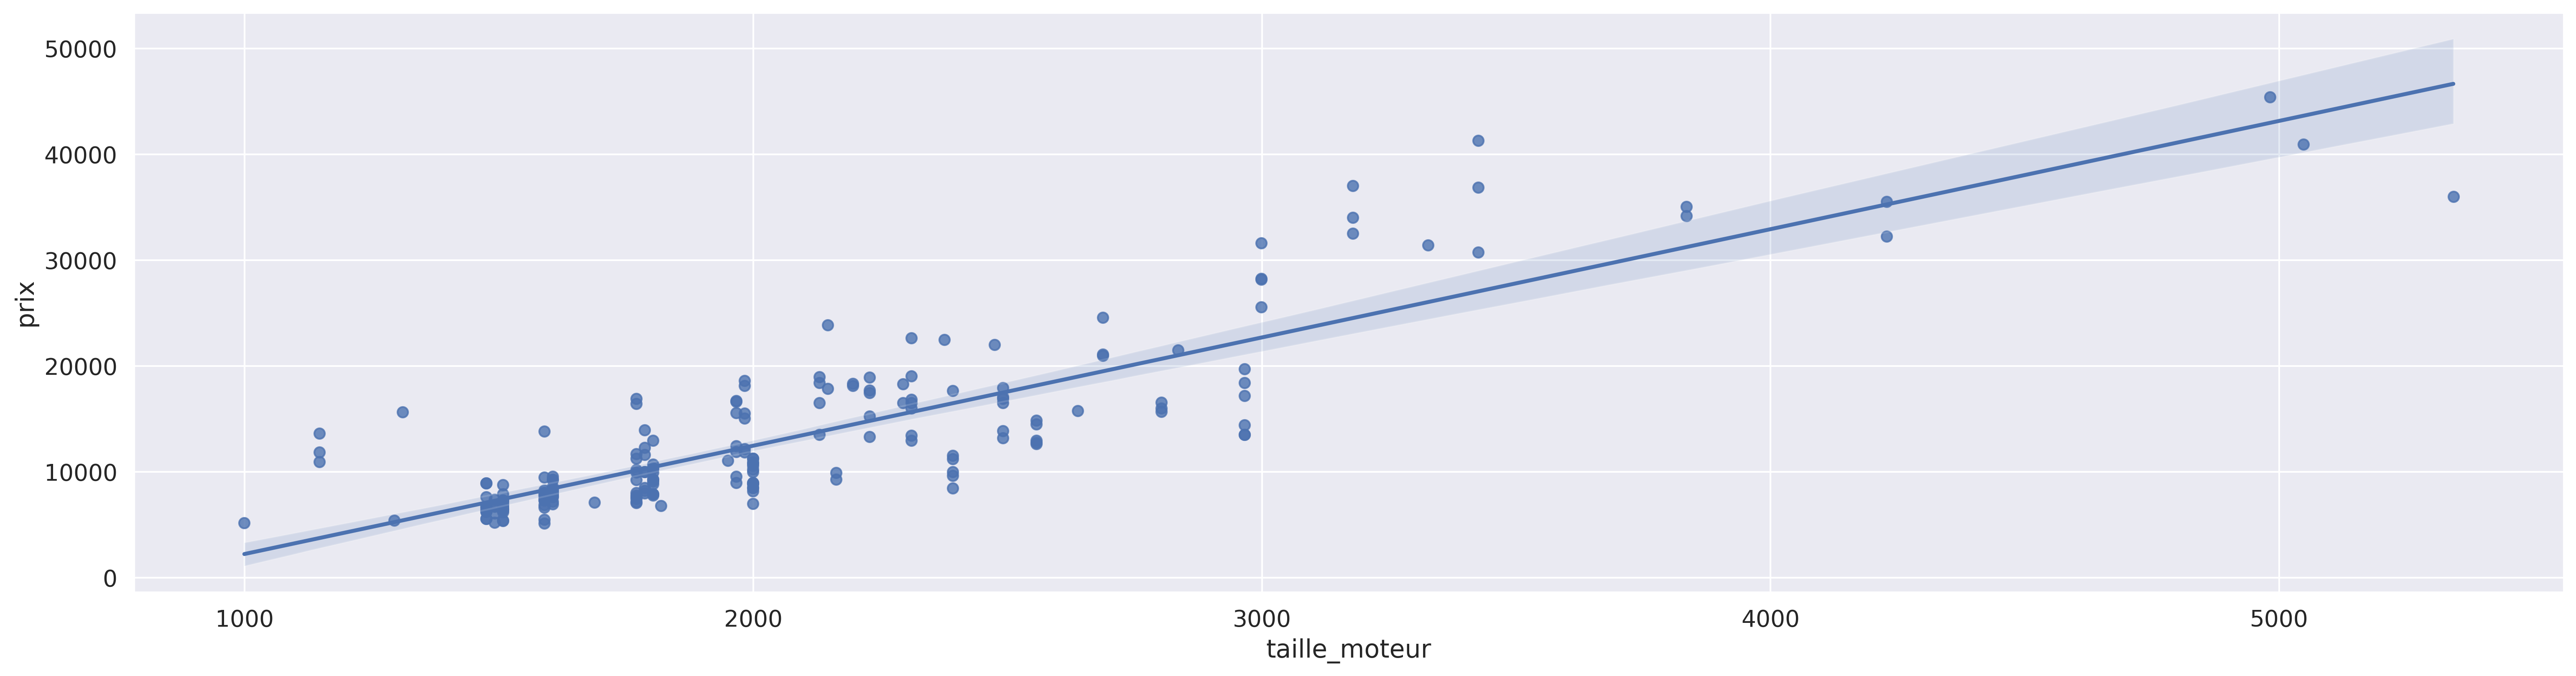

In [90]:
plt.figure(figsize=(25,6),dpi=300)
relplot = sns.regplot(data=df, x="taille_moteur", y="prix")

<Axes: ylabel='nombre_portes'>

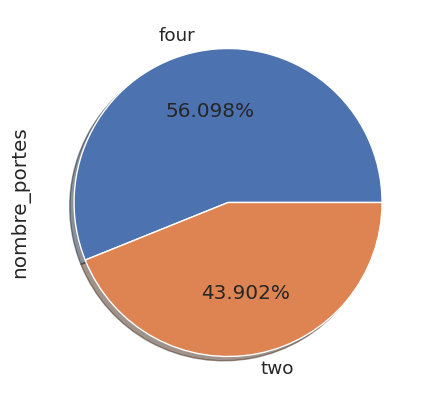

In [91]:
plt.figure(figsize = [5, 5], clear = True, facecolor = "#ffffff")
df["nombre_portes"].value_counts().plot.pie( autopct='%1.3f%%', shadow = True)

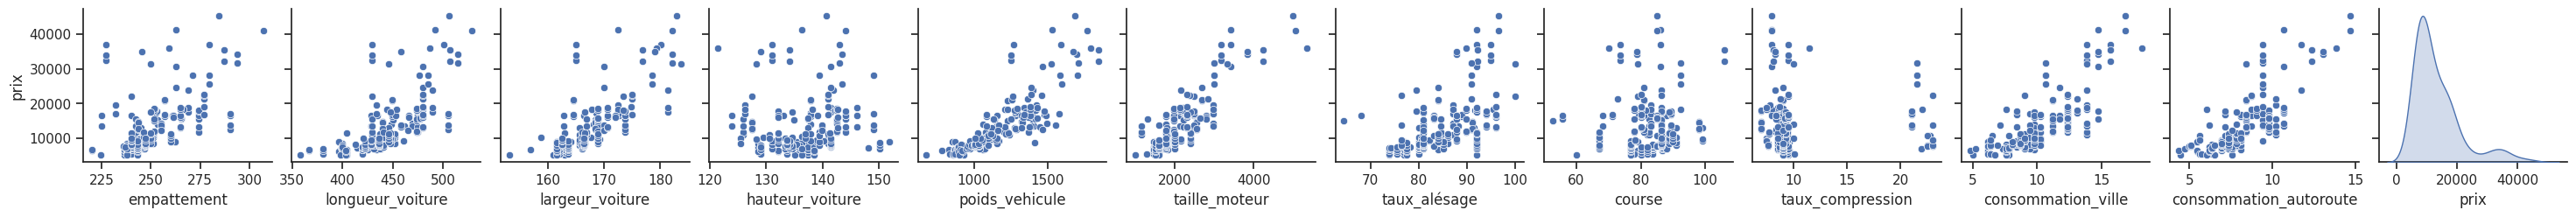

In [92]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df, x_vars=df.columns[df.dtypes == float], y_vars=["prix"], kind="scatter", diag_kind="kde")
plt.show()

### 5) Encodage et transformation (normalisation) des variables

In [93]:
categorial_features = ['etat_de_route', 'carburant', 'turbo', 'nombre_portes', 'type_vehicule', 'transmission', 'emplacement_moteur', 'type_moteur', 'nombre_cylindres', 'systeme_carburant', 'marque_de_voiture']
numeric_features = ['empattement', 'longueur_voiture', 'largeur_voiture', 'hauteur_voiture', 'poids_vehicule', 'taille_moteur', 'taux_alésage', 'course', 'taux_compression', 'chevaux', 'tour_moteur', 'consommation_ville', 'consommation_autoroute']
           
cat_feat = Pipeline(steps=[
    ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
])

num_feat = Pipeline(steps=[
    ('MinMaxScaler', MinMaxScaler()),
])


preprocessor = ColumnTransformer(
    transformers=[
        ('onehotencoder', cat_feat, categorial_features),
        ('MinMaxScaler', num_feat, numeric_features)
    ])


X_cat_transformed = cat_feat.fit_transform(df[categorial_features])
X_num_transformed = num_feat.fit_transform(df[numeric_features])


X_cat_transformed_df = pd.DataFrame(X_cat_transformed.toarray(),
                                    columns=cat_feat['onehotencoder'].get_feature_names_out(categorial_features))

# Convert the transformed features to a pandas DataFrame
X_num_transformed_df = pd.DataFrame(X_num_transformed, columns=numeric_features)

# Combine the one-hot encoded categorical variables and the target variable into a single dataframe
df_combined = pd.concat([X_cat_transformed_df, X_num_transformed_df, df['prix']], axis=1)


In [94]:
df_combined.head()

,etat_de_route_-2,etat_de_route_-1,etat_de_route_0,etat_de_route_1,etat_de_route_2,etat_de_route_3,carburant_diesel,carburant_gas,turbo_std,turbo_turbo,...,poids_vehicule,taille_moteur,taux_alésage,course,taux_compression,chevaux,tour_moteur,consommation_ville,consommation_autoroute,prix
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.411171,0.260377,0.664286,0.290476,0.1250,0.262500,0.346939,0.481481,0.421053,13495.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.411171,0.260377,0.664286,0.290476,0.1250,0.262500,0.346939,0.481481,0.421053,16500.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.517843,0.343396,0.100000,0.666667,0.1250,0.441667,0.346939,0.570175,0.453441,16500.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.329325,0.181132,0.464286,0.633333,0.1875,0.225000,0.551020,0.376157,0.336842,13950.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.518231,0.283019,0.464286,0.633333,0.0625,0.279167,0.551020,0.621914,0.612440,17450.0


### 6) Calcul de la corrélation entre la variables prix et les autres variables

<Axes: >

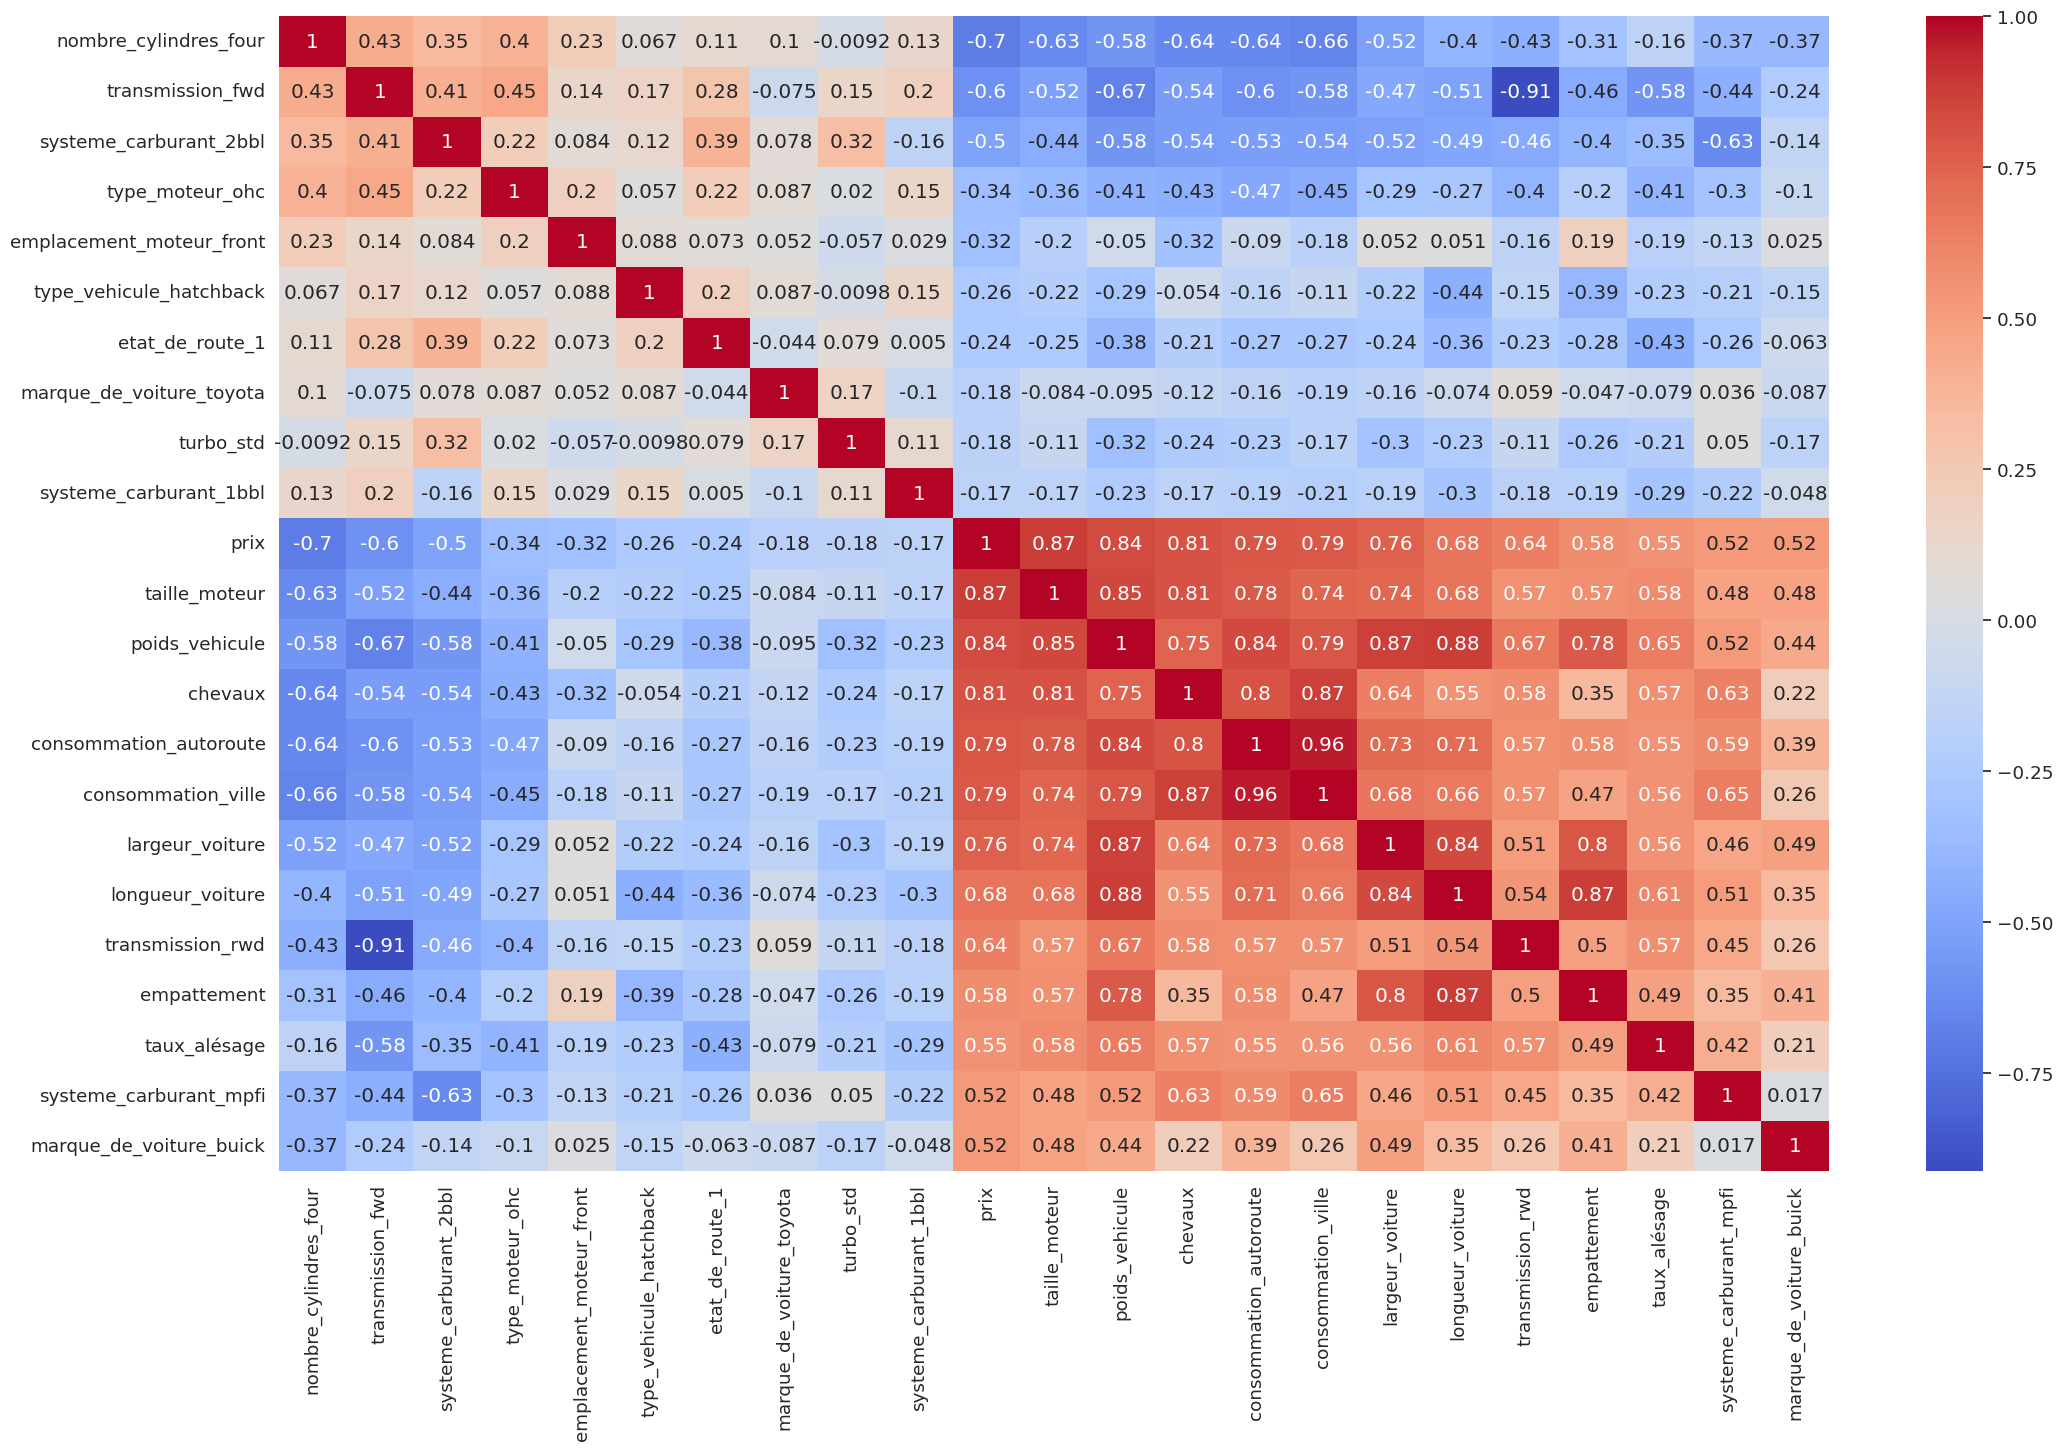

In [95]:
# Calculate the correlation between all the variables
corr_matrix = df_combined.corr()

# Get the 10 highest and 10 lowest correlations with the 'prix' variable

top_corr = corr_matrix['prix'].sort_values(ascending=False).head(13)
bot_corr = corr_matrix['prix'].sort_values().head(10)
top_corr = pd.concat([bot_corr, top_corr])

# Plot heatmap
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(corr_matrix.loc[top_corr.index, top_corr.index], annot=True, cmap='coolwarm')

In [116]:
top_corr

nombre_cylindres_four      -0.697762
transmission_fwd           -0.601950
systeme_carburant_2bbl     -0.501374
type_moteur_ohc            -0.344270
emplacement_moteur_front   -0.324973
type_vehicule_hatchback    -0.262039
etat_de_route_1            -0.243036
marque_de_voiture_toyota   -0.182997
turbo_std                  -0.177926
systeme_carburant_1bbl     -0.170945
prix                        1.000000
taille_moteur               0.874145
poids_vehicule              0.835305
chevaux                     0.808139
consommation_autoroute      0.791044
consommation_ville          0.788600
largeur_voiture             0.759325
longueur_voiture            0.682920
transmission_rwd            0.638957
empattement                 0.577816
taux_alésage                0.553173
systeme_carburant_mpfi      0.517075
marque_de_voiture_buick     0.515094
Name: prix, dtype: float64

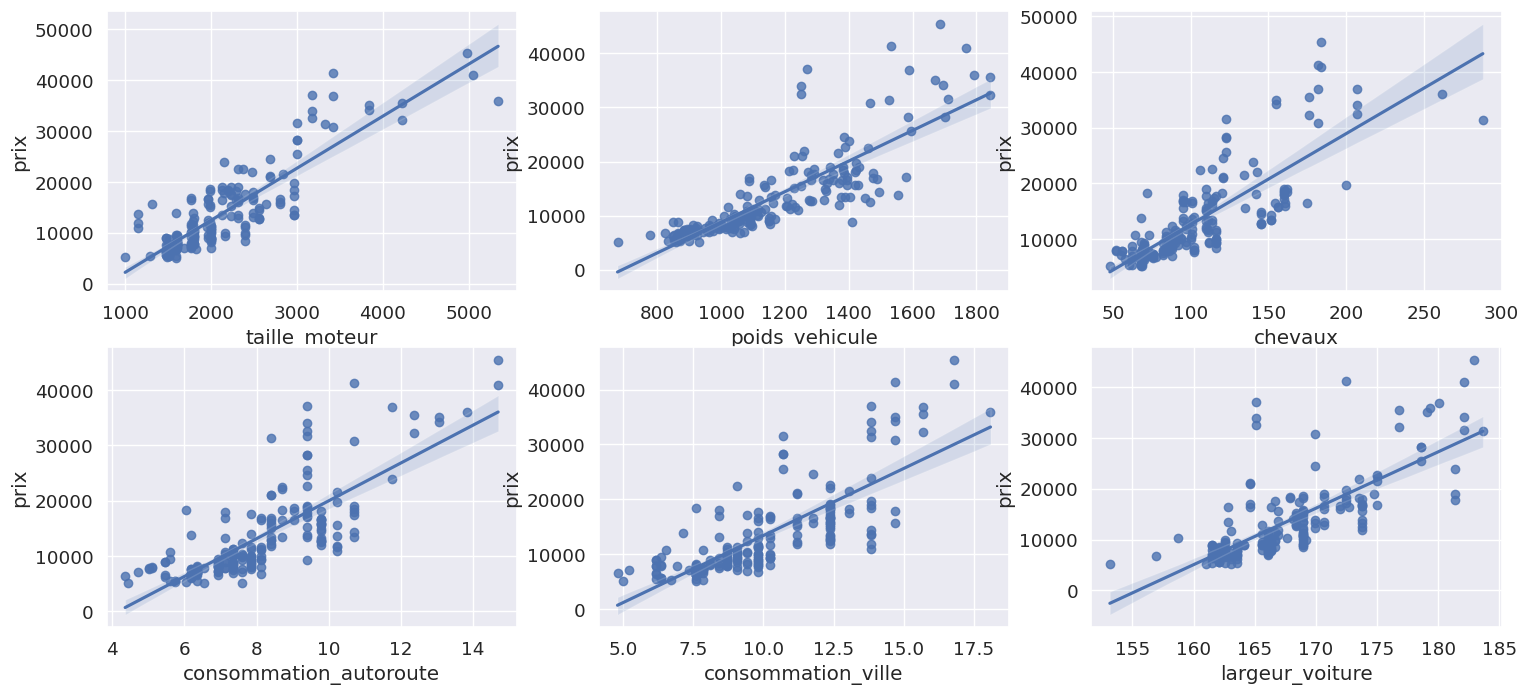

In [96]:
columns=['taille_moteur','poids_vehicule','chevaux','consommation_autoroute','consommation_ville','largeur_voiture']
plt.figure(figsize=(18, 8))
i=0
for col in columns:
    i=i+1
    plt.subplot(2,3,i)
    sns.regplot(x = col, y = 'prix', data = df)
plt.show()


In [97]:
print(top_corr)

nombre_cylindres_four      -0.697762
transmission_fwd           -0.601950
systeme_carburant_2bbl     -0.501374
type_moteur_ohc            -0.344270
emplacement_moteur_front   -0.324973
type_vehicule_hatchback    -0.262039
etat_de_route_1            -0.243036
marque_de_voiture_toyota   -0.182997
turbo_std                  -0.177926
systeme_carburant_1bbl     -0.170945
prix                        1.000000
taille_moteur               0.874145
poids_vehicule              0.835305
chevaux                     0.808139
consommation_autoroute      0.791044
consommation_ville          0.788600
largeur_voiture             0.759325
longueur_voiture            0.682920
transmission_rwd            0.638957
empattement                 0.577816
taux_alésage                0.553173
systeme_carburant_mpfi      0.517075
marque_de_voiture_buick     0.515094
Name: prix, dtype: float64


### 6) Spliting data 

In [98]:
X= df.drop('prix', axis =1)
y = df['prix']

In [99]:
X.columns

Index(['etat_de_route', 'marque_de_voiture', 'carburant', 'turbo',
       'nombre_portes', 'type_vehicule', 'transmission', 'emplacement_moteur',
       'empattement', 'longueur_voiture', 'largeur_voiture', 'hauteur_voiture',
       'poids_vehicule', 'type_moteur', 'nombre_cylindres', 'taille_moteur',
       'systeme_carburant', 'taux_alésage', 'course', 'taux_compression',
       'chevaux', 'tour_moteur', 'consommation_ville',
       'consommation_autoroute'],
      dtype='object')

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [101]:
print("Traing Data Shape of x and y respectively:  ", X_train.shape, y_train.shape)
print("Testing Data Shape of x and y respectively:  ", X_test.shape, y_test.shape)

Traing Data Shape of x and y respectively:   (164, 24) (164,)
Testing Data Shape of x and y respectively:   (41, 24) (41,)


### 7) Building Model

* LinearRegression

In [102]:
categorial_features = ['transmission', 'nombre_cylindres', 'systeme_carburant']

numeric_features = ['poids_vehicule', 'taille_moteur', 'chevaux', 'consommation_autoroute' , 'consommation_ville', 'longueur_voiture', 'largeur_voiture']

# Define the column transformer to apply the OneHotEncoder to categorical features
# and the MinMaxScaler to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorial_features),
        ('num', MinMaxScaler(), numeric_features)
    ])

# Define the pipeline that combines the preprocessor with the linear regression model
model_LR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline on the data
model_LR.fit(X_train, y_train)

# Predict on the test set
y_pred = model_LR.predict(X_test)


In [103]:
# Evaluate the model
score = model_LR.score(X_test, y_test)
print("R-squared score on test set: ", score)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE): ", mse)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE): ", mae)

R-squared score on test set:  0.857930652614218
Mean Squared Error (MSE):  11215525.526382515
Mean Absolute Error (MAE):  2263.3921086676787


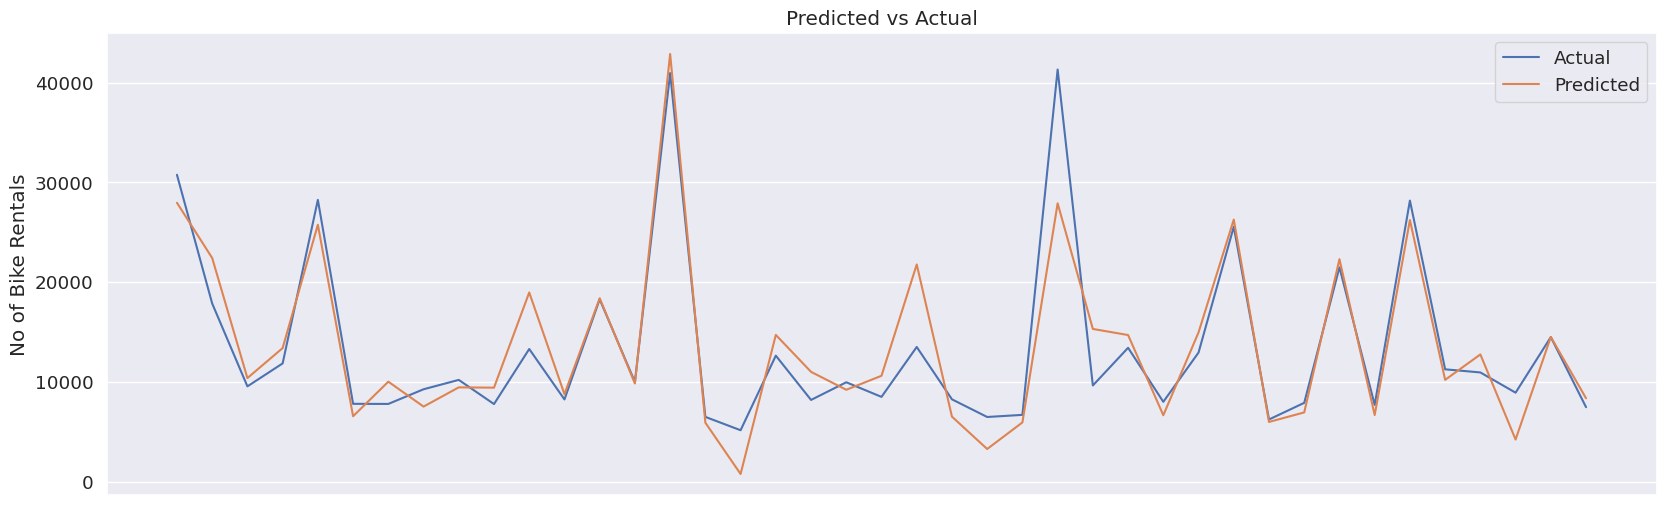

In [104]:

# Plotting Actual vs Predicted No of rentals 
fig,ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)
l1,=ax.plot(range(len(y_test)),y_test)
l2, = ax.plot(range(len(y_pred)),y_pred)
plt.legend([l1,l2],['Actual','Predicted'])
plt.title('Predicted vs Actual');
plt.ylabel('No of Bike Rentals')
plt.xticks([])
plt.show()

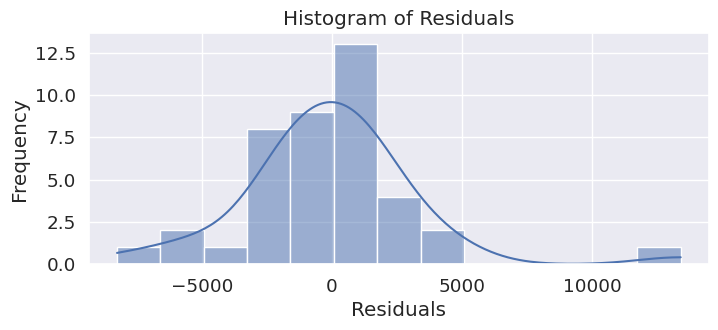

In [105]:
# Generate histogram of residuals
fig, ax = plt.subplots(figsize=(8, 3))
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

* DecisionTreeRegressor

In [106]:
categorial_features = ['etat_de_route', 'carburant', 'turbo', 'nombre_portes', 'type_vehicule', 'transmission', 'emplacement_moteur', 'type_moteur', 'nombre_cylindres', 'systeme_carburant', 'marque_de_voiture']

numeric_features = ['empattement', 'longueur_voiture', 'largeur_voiture', 'hauteur_voiture', 'poids_vehicule', 'taille_moteur', 'taux_alésage', 'course', 'taux_compression', 'chevaux', 'tour_moteur', 'consommation_ville', 'consommation_autoroute']

# Define the column transformer to apply the OneHotEncoder to categorical features
# and the MinMaxScaler to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorial_features),
        ('num', MinMaxScaler(), numeric_features)
    ])

# Define the pipeline that combines the preprocessor with the linear regression model
model_DT = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])

# Fit the pipeline on the data
model_DT.fit(X_train, y_train)

# Predict on the test set
y_pred = model_DT.predict(X_test)

In [107]:
# Evaluate the model
score = model_DT.score(X_test, y_test)
print("R-squared score on test set: ", score)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE): ", mse)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE): ", mae)

R-squared score on test set:  0.908771537185882
Mean Squared Error (MSE):  7201941.673216805
Mean Absolute Error (MAE):  1788.516268292683


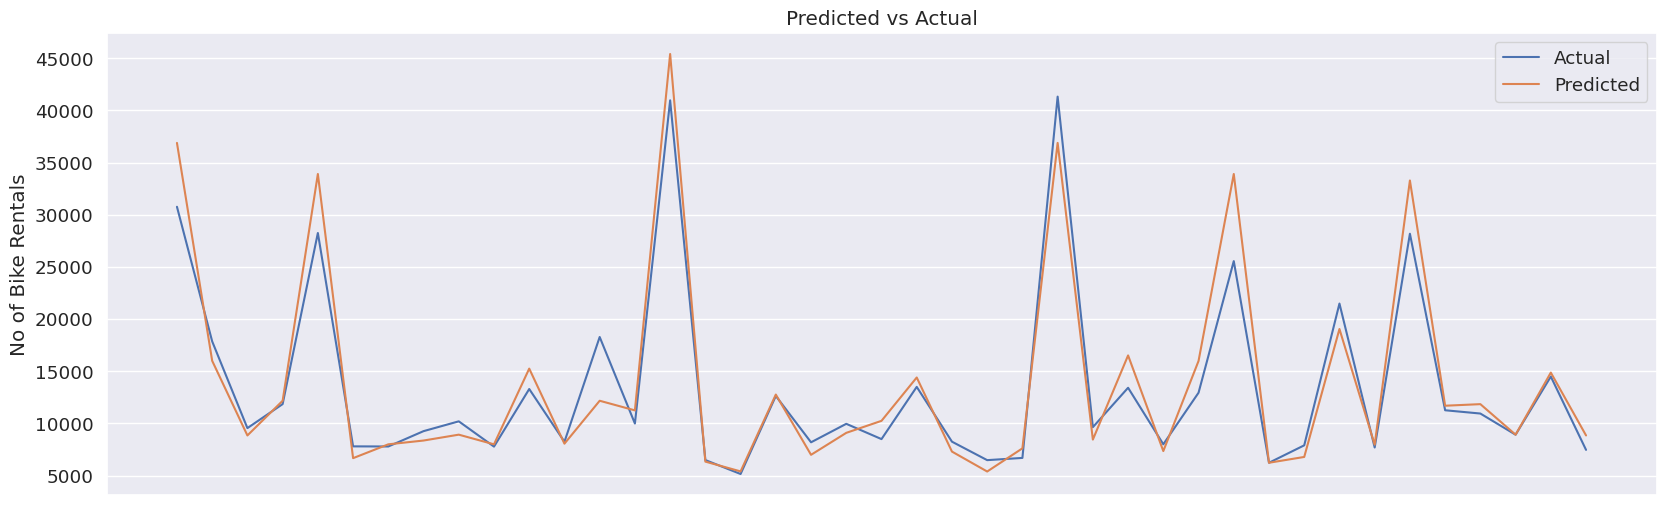

In [108]:
# Plotting Actual vs Predicted No of rentals 
fig,ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)
l1,=ax.plot(range(len(y_test)),y_test)
l2, = ax.plot(range(len(y_pred)),y_pred)
plt.legend([l1,l2],['Actual','Predicted'])
plt.title('Predicted vs Actual');
plt.ylabel('No of Bike Rentals')
plt.xticks([])
plt.show()


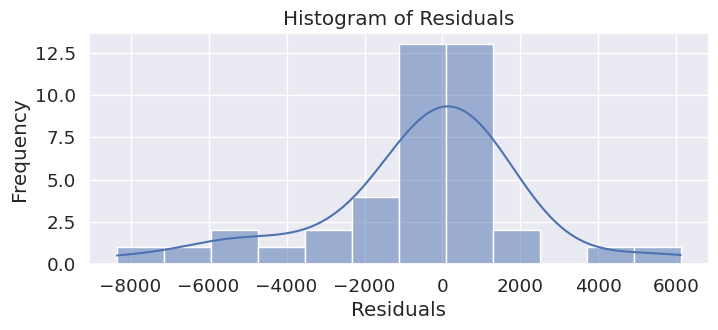

In [109]:
# Generate histogram of residuals
fig, ax = plt.subplots(figsize=(8, 3))
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

* RandomForestRegressor

In [110]:
categorial_features = ['etat_de_route', 'carburant', 'turbo', 'nombre_portes', 'type_vehicule', 'transmission', 'emplacement_moteur', 'type_moteur', 'nombre_cylindres', 'systeme_carburant', 'marque_de_voiture']

numeric_features = ['empattement', 'longueur_voiture', 'largeur_voiture', 'hauteur_voiture', 'poids_vehicule', 'taille_moteur', 'taux_alésage', 'course', 'taux_compression', 'chevaux', 'tour_moteur', 'consommation_ville', 'consommation_autoroute']

# Define the column transformer to apply the OneHotEncoder to categorical features
# and the MinMaxScaler to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorial_features),
        ('num', MinMaxScaler(), numeric_features)
    ])

# Define the pipeline that combines the preprocessor with the linear regression model
model_RF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators = 15,
                              criterion = 'squared_error',
                              random_state = 20,
                              n_jobs = -1))
])

# Fit the pipeline on the data
model_RF.fit(X_train, y_train)

# Predict on the test set
y_pred = model_RF.predict(X_test)

In [111]:
# Evaluate the model
score = model_RF.score(X_test, y_test)
print("R-squared score on test set: ", score)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE): ", mse)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE): ", mae)

R-squared score on test set:  0.9554781553315184
Mean Squared Error (MSE):  3514733.4351094887
Mean Absolute Error (MAE):  1302.4496016260161


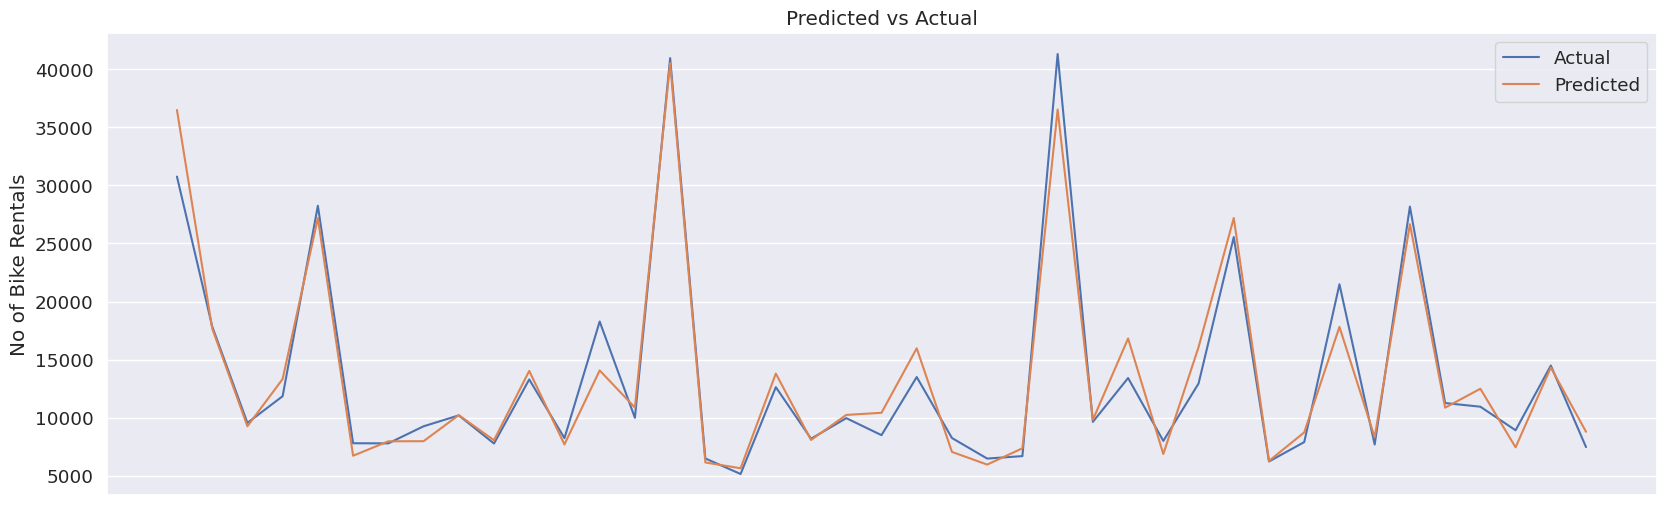

In [112]:
# Plotting Actual vs Predicted No of rentals 
fig,ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)
l1,=ax.plot(range(len(y_test)),y_test)
l2, = ax.plot(range(len(y_pred)),y_pred)
plt.legend([l1,l2],['Actual','Predicted'])
plt.title('Predicted vs Actual');
plt.ylabel('No of Bike Rentals')
plt.xticks([])
plt.show()


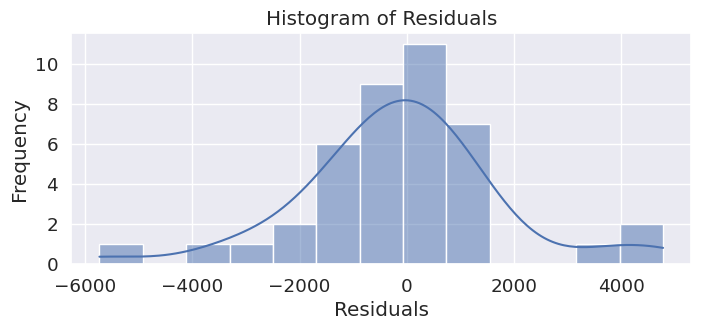

In [113]:
# Generate histogram of residuals
fig, ax = plt.subplots(figsize=(8, 3))
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

### 8) Application streamlit

In [ ]:
with open('modèles_previsions.pkl', 'wb') as file:
    pickle.dump(model_RF, file)



Insights:

    There's some cars its wheel base make a differance and affect on price of this car.

    The bigger the number of engine size, the more expensive the car usually is to buy.

    There're some outliters values but almost by increasing boreratio the price is increasing.

    Bore ratio of car and the rate of feul consumption are factors affect on the performance of car and also price.

    By increasinng car length and width values, price is increaing.

    The heavier the vehicle, the more energy it needs to get moving.

    By increasing curbweight, the price of cars will be affect but not more because there are more outliters.

